In [1]:
from os import path
import pandas as pd
from IPython.display import display
from matplotlib import pyplot as plt
from laptrack import LapTrack
from laptrack import datasets
import napari
from skimage import io

In [2]:
##loading spots 
# Assuming 'your_file.pkl' is the name of your pickle file
file_path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/track_df_c3_all.pkl'

# Read the pickle file into a Pandas DataFrame
track_df = pd.read_pickle(file_path)


In [3]:
# Find the count of each tree_id
tree_id_counts = track_df['track_id'].value_counts()

# Get the tree_ids that have occurred more than 8 times
selected_tree_ids = tree_id_counts[tree_id_counts > 9].index

# Filter the DataFrame to get rows with the selected tree_ids
filtered_df = track_df[track_df['track_id'].isin(selected_tree_ids)]
filtered_df = filtered_df.reset_index()
# Print the filtered DataFrame
#filtered_df.head()

# FINDING TOTAL DISTANCE TRAVELLED 

In [4]:
#total_distance_df = filtered_df.copy(deep = True)
total_distance_df = filtered_df.copy(deep = True)

In [5]:
total_distance_df.head()

,level_0,frame,index,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame_y,tree_id,track_id
0,0,0,0,206.593249,11.0,12.0,0.0,2.0,2.0,4.0,0,0,0
1,9,0,9,254.409872,73.0,29.0,0.0,2.0,2.0,4.0,0,9,9
2,28,0,28,239.397881,113.0,100.0,2.0,2.0,2.0,3.0,0,28,28
3,29,0,29,219.333333,120.0,238.0,2.0,2.0,1.0,3.0,0,29,29
4,30,0,30,285.000000,130.0,153.0,2.0,2.0,2.0,2.0,0,30,30


In [6]:
# Calculate the displacement for each frame within each track
total_distance_df['dx'] = total_distance_df.groupby('track_id')['mu_x'].diff()
total_distance_df['dy'] = total_distance_df.groupby('track_id')['mu_y'].diff()
total_distance_df['dz'] = total_distance_df.groupby('track_id')['mu_z'].diff()

##verification of the above
#filtered_df[filtered_df['track_id'] == 319]

# Fill NaN values with 0 for the first frame of each track
total_distance_df[['dx', 'dy', 'dz']] = total_distance_df.groupby('track_id')[['dx', 'dy', 'dz']].transform(lambda x: x.fillna(0))

##verification of the above
#filtered_df[filtered_df['track_id'] == 319]

# Calculate the cumulative sum of displacements within each track
total_distance_df['cumulative_dx'] = total_distance_df.groupby('track_id')['dx'].cumsum()
total_distance_df['cumulative_dy'] = total_distance_df.groupby('track_id')['dy'].cumsum()
total_distance_df['cumulative_dz'] = total_distance_df.groupby('track_id')['dz'].cumsum()

##verification of the above
#filtered_df[filtered_df['track_id'] == 319]

# Calculate the Euclidean distance as the total movement
total_distance_df['total_movement'] = (total_distance_df['cumulative_dx']**2 + total_distance_df['cumulative_dy']**2 + total_distance_df['cumulative_dz']**2)**0.5

##verification of the above
#filtered_df[filtered_df['track_id'] == 319]

# Get the maximum total movement for each track
max_movement_per_track = total_distance_df.groupby('track_id')['total_movement'].max()

#max_movement_per_track

# Sort and reset index to keep track of the original track IDs
sorted_max_movement_with_index = max_movement_per_track.sort_values(ascending=False).reset_index()

In [7]:
sorted_max_movement_with_index.head()

,track_id,total_movement
0,12757,22.315914
1,11026,18.973666
2,6135,16.822604
3,6555,16.309506
4,253,16.309506


In [8]:
# Assuming you have a list of 10 track IDs named selected_track_ids
longest_track_ids = sorted_max_movement_with_index['track_id'][0:10].values # Replace with your actual track IDs
longest_track_ids.reshape(-1,1)
longest_track_ids
# Assuming you have a main dataframe named main_dataframe

# Filter the main dataframe based on the selected track IDs
filtered_longest_tracks = filtered_df[filtered_df['track_id'].isin(longest_track_ids)]

filtered_longest_tracks['track_id'].unique()

array([  253,  4291,  4436,  6135,  6555, 10410, 11026, 11976, 12757,
       13218])

In [9]:
# Assuming you have a list of 10 track IDs named selected_track_ids
selected_track_ids_shortest = sorted_max_movement_with_index['track_id'][-10:].values # Replace with your actual track IDs
selected_track_ids_shortest.reshape(-1,1)
selected_track_ids_shortest
# Assuming you have a main dataframe named main_dataframe

# Filter the main dataframe based on the selected track IDs
filtered_shortest_paths = filtered_df[filtered_df['track_id'].isin(selected_track_ids_shortest)]

filtered_shortest_paths['track_id'].unique()

array([ 2152,  2776,  2955,  3108,  4922,  6792,  6934,  9493, 18520,
       18605])

In [10]:
# Define the distance ranges

distance_ranges = [(5, 6), (6, 7), (7, 8), (8, 9)]

# Initialize an empty DataFrame to store the selected rows
selected_rows = pd.DataFrame()

# Randomly pick 2 rows for each distance range
for start, end in distance_ranges:
    subset = sorted_max_movement_with_index[(sorted_max_movement_with_index['total_movement'] >= start) 
                                            & (sorted_max_movement_with_index['total_movement'] < end)]
    selected_rows = pd.concat([selected_rows, subset.sample(2)])

# Display the selected rows
selected_rows


,track_id,total_movement
614,2997,5.744563
649,539,5.477226
379,2424,6.782330
432,5916,6.633250
252,5297,7.810250
335,1558,7.141428
199,9511,8.306624
197,2239,8.306624


In [11]:

# Assuming you have a list of 10 track IDs named selected_track_ids
selected_track_ids_random = selected_rows['track_id'].values # Replace with your actual track IDs
selected_track_ids_random.reshape(-1,1)
selected_track_ids_random
# Assuming you have a main dataframe named main_dataframe

# Filter the main dataframe based on the selected track IDs
filtered_random_tracks = filtered_df[filtered_df['track_id'].isin(selected_track_ids_random)]

filtered_random_tracks['track_id'].unique()


array([ 539, 1558, 2239, 2424, 2997, 5297, 5916, 9511])

# VISUALISING THROUGH NAPARI

In [ ]:
'''
I have added the points layer instead of adding these
# Replace 'your_file.tif' with the path to your 4D TIFF file
file_path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/spots_c2_all.tif'

# Load the TIFF file using skimage
stack = io.imread(file_path)

# Create a napari viewer
viewer = napari.Viewer()

# Add the 4D stack to the viewer
layer = viewer.add_image(stack)
'''

In [12]:

# Create a napari viewer
viewer = napari.Viewer()

# Replace 'your_file.tif' with the path to your 4D TIFF file
file_path = '/Users/apple/Desktop/Akamatsu_Lab/Lap_track/self/files/Channel_2.tif'

# Load the TIFF file using skimage
raw_image = io.imread(file_path)

# Add the 4D stack to the viewer
layer_raw = viewer.add_image(raw_image)

1   HIToolbox                           0x00007ff817554726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff8175542b8 _ZN15MenuBarInstance14EnableAutoShowEv + 52
3   HIToolbox                           0x00007ff8174c3cd7 _ZN15MenuBarInstance21UpdateAggregateUIModeE21MenuBarAnimationStylehhh + 1113
4   HIToolbox                           0x00007ff817554173 _ZN15MenuBarInstance19SetFullScreenUIModeEjj + 175
5   AppKit                              0x00007ff8110254b7 -[NSApplication _setPresentationOptions:instance:flags:] + 1145
6   AppKit                              0x00007ff810e7a165 -[NSApplication _updateFullScreenPresentationOptionsForInstance:] + 582
7   AppKit                              0x00007ff8118c8a40 -[_NSFullScreenSpace(PresentationInstance) activateFullScreenPresentationOptions] + 207
8   AppKit                              0x00007ff81171b848 -[_NSEnterFullScreenTransitionController _doSucceededToEnterFullScreen] + 721


In [13]:
#layer.bounding_box.visible = True
layer_raw.bounding_box.visible = True

In [14]:
viewer.add_tracks(filtered_longest_tracks[["track_id", "frame", "mu_z", "mu_y", "mu_x"]])
viewer.add_tracks(filtered_shortest_paths[["track_id", "frame", "mu_z", "mu_y", "mu_x"]])
viewer.add_tracks(filtered_random_tracks[["track_id", "frame", "mu_z", "mu_y", "mu_x"]])

<Tracks layer 'Tracks [2]' at 0x7ff1ca578e80>

In [15]:
points_layer = viewer.add_points(filtered_longest_tracks[["frame", "mu_z", "mu_y", "mu_x"]], size=3, 
                                name = 'longest_track_points', face_color = 'r', symbol = 'ring')
points_layer = viewer.add_points(filtered_shortest_paths[["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'shortest_track_points', face_color = 'y', symbol = 'ring')
points_layer = viewer.add_points(filtered_random_tracks[["frame", "mu_z", "mu_y", "mu_x"]], size=3,
                                name = 'random_track_points', face_color = 'pink', symbol = 'ring')

In [16]:
points_layer = viewer.add_points(filtered_df[["frame", "mu_z", "mu_y", "mu_x"]], size=1,
                                name = 'all_points', face_color = 'white', symbol = 'o')

In [17]:
viewer.add_tracks(filtered_df[["track_id", "frame", "mu_z", "mu_y", "mu_x"]])

<Tracks layer 'Tracks [3]' at 0x7ff1d1dea950>

In [ ]:
'''
#Taking screenshots with napari, 0 ,0 for x and y means take image of the entire image. 
viewer.dims.current_step = (0, 38, 0, 0)
plt.imshow(viewer.screenshot())
plt.xticks([])
plt.yticks([])

'''

## Manually pick 10 tracks which look like CME sites 
226, 332, 767, 689, 646, 393, 778, 566, 551, 710

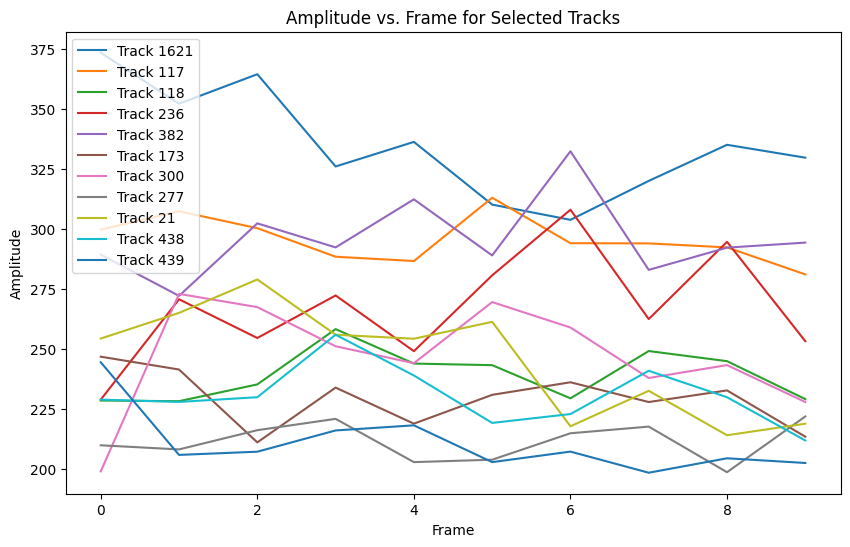

1   HIToolbox                           0x00007ff817554726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff81751d638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff8127c374d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff812ad604a _ZN21CGSDatagramReadStream26dispatchMainQueueDatagramsEv + 202
5   SkyLight                            0x00007ff812ad5f71 ___ZN21CGSDatagramReadStream15mainQueueWakeupEv_block_invoke + 18
6   libdispatch.dylib                   0x00007ff80d9427fb _dispatch_call_block_and_release + 12
7   libdispatch.dylib                   0x00007ff80d943a44 _dispatch_client_callout + 8
8   libdispatch.dylib                   0x00007ff80d9507b9 _dispatch_main_queue_drain + 952
9   libdispatch.dylib                   0x00007ff80d9503f3 _dispatch_main_queue_callback_4CF + 31
10  CoreFoundation                      

1   HIToolbox                           0x00007ff817554726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff81751d638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff8127c374d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff812ad604a _ZN21CGSDatagramReadStream26dispatchMainQueueDatagramsEv + 202
5   SkyLight                            0x00007ff812ad5f71 ___ZN21CGSDatagramReadStream15mainQueueWakeupEv_block_invoke + 18
6   libdispatch.dylib                   0x00007ff80d9427fb _dispatch_call_block_and_release + 12
7   libdispatch.dylib                   0x00007ff80d943a44 _dispatch_client_callout + 8
8   libdispatch.dylib                   0x00007ff80d9507b9 _dispatch_main_queue_drain + 952
9   libdispatch.dylib                   0x00007ff80d9503f3 _dispatch_main_queue_callback_4CF + 31
10  CoreFoundation                      

1   HIToolbox                           0x00007ff817554726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff8174f8852 SetMenuBarObscured + 226
3   HIToolbox                           0x00007ff8174f84ca _ZN13HIApplication15HandleActivatedEP14OpaqueEventRefhP15OpaqueWindowPtrh + 164
4   HIToolbox                           0x00007ff8174f2996 _ZN13HIApplication13EventObserverEjP14OpaqueEventRefPv + 252
5   HIToolbox                           0x00007ff8174babd2 _NotifyEventLoopObservers + 153
6   HIToolbox                           0x00007ff8174f23e6 AcquireEventFromQueue + 494
7   HIToolbox                           0x00007ff8174e13ec ReceiveNextEventCommon + 285
8   HIToolbox                           0x00007ff8174e12b3 _BlockUntilNextEventMatchingListInModeWithFilter + 70
9   AppKit                              0x00007ff810ce8f33 _DPSNextEvent + 909
10  AppKit                              0x00007ff810ce7db4 -[NSApplication(NSEvent) _ne

1   HIToolbox                           0x00007ff817554726 _ZN15MenuBarInstance22EnsureAutoShowObserverEv + 102
2   HIToolbox                           0x00007ff81751d638 _ZL17BroadcastInternaljPvh + 167
3   SkyLight                            0x00007ff8127c374d _ZN12_GLOBAL__N_123notify_datagram_handlerEj15CGSDatagramTypePvmS1_ + 1030
4   SkyLight                            0x00007ff812ad604a _ZN21CGSDatagramReadStream26dispatchMainQueueDatagramsEv + 202
5   SkyLight                            0x00007ff812ad5f71 ___ZN21CGSDatagramReadStream15mainQueueWakeupEv_block_invoke + 18
6   libdispatch.dylib                   0x00007ff80d9427fb _dispatch_call_block_and_release + 12
7   libdispatch.dylib                   0x00007ff80d943a44 _dispatch_client_callout + 8
8   libdispatch.dylib                   0x00007ff80d9507b9 _dispatch_main_queue_drain + 952
9   libdispatch.dylib                   0x00007ff80d9503f3 _dispatch_main_queue_callback_4CF + 31
10  CoreFoundation                      

In [23]:
# List of track IDs to plot
selected_track_ids = [1621,117,118,236, 382, 173, 300,277,21,438,439]

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over selected track IDs and plot each track
for track_id in selected_track_ids:
    track_data = filtered_df[filtered_df['track_id'] == track_id]
    ax.plot(track_data['frame'], track_data['amplitude'], label=f'Track {track_id}')

# Customize the plot
ax.set_xlabel('Frame')
ax.set_ylabel('Amplitude')
ax.set_title('Amplitude vs. Frame for Selected Tracks')
ax.legend()

# Show the plot
plt.show()

In [27]:
temp = filtered_df[filtered_df['track_id'] == 697]
temp

,frame,index,amplitude,mu_x,mu_y,mu_z,sigma_x,sigma_y,sigma_z,frame_y,tree_id,track_id
82,0,697,179.333333,219.0,122.0,67.0,3.0,2.0,4.0,0,697,697
197,1,474,184.333333,220.0,122.0,66.0,4.0,3.0,5.0,1,697,697
332,2,491,183.601088,220.0,122.0,67.0,2.0,2.0,5.0,2,697,697
465,3,453,186.000000,221.0,126.0,66.0,4.0,6.0,3.0,3,697,697
600,4,435,210.107574,220.0,124.0,67.0,2.0,3.0,3.0,4,697,697
730,5,429,177.354761,219.0,125.0,67.0,2.0,2.0,4.0,5,697,697
885,6,492,204.000000,217.0,125.0,69.0,1.0,1.0,3.0,6,697,697
992,7,356,185.000000,219.0,124.0,64.0,1.0,1.0,3.0,7,697,697
1139,8,441,196.000000,219.0,120.0,67.0,2.0,5.0,3.0,8,697,697
1256,9,415,207.428319,218.0,117.0,68.0,2.0,2.0,4.0,9,697,697


Visualising Amplitude over time 

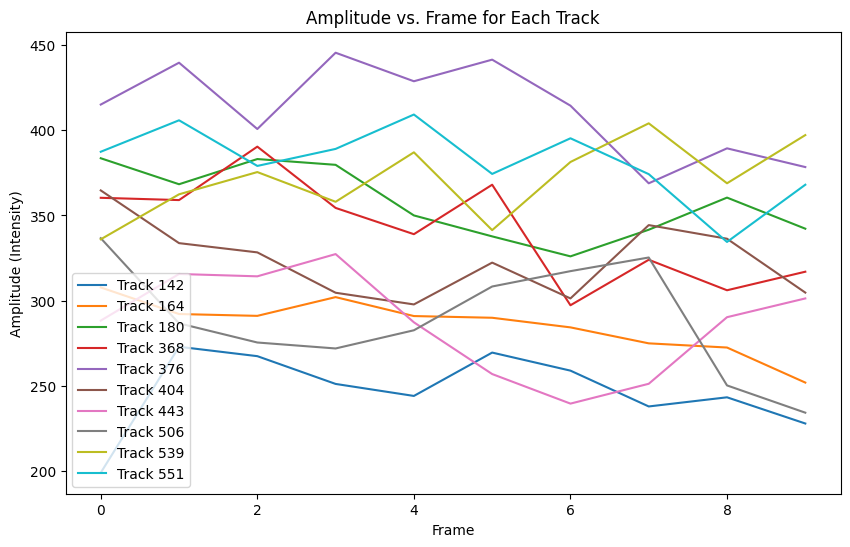

In [12]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique tracks and plot each track
for track_id, track_data in filtered_shortest_paths.groupby('track_id'):
    ax.plot(track_data['frame'], track_data['amplitude'], label=f'Track {track_id}')

# Customize the plot
ax.set_xlabel('Frame')
ax.set_ylabel('Amplitude (Intensity)')
ax.set_title('Amplitude vs. Frame for Each Track')
ax.legend()

# Show the plot
plt.show()

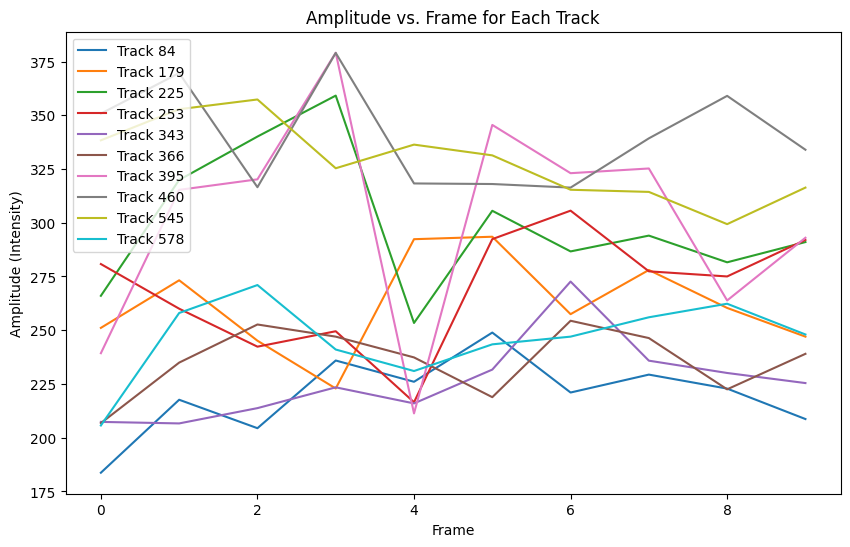

In [13]:
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over unique tracks and plot each track
for track_id, track_data in filtered_longest_tracks.groupby('track_id'):
    ax.plot(track_data['frame'], track_data['amplitude'], label=f'Track {track_id}')

# Customize the plot
ax.set_xlabel('Frame')
ax.set_ylabel('Amplitude (Intensity)')
ax.set_title('Amplitude vs. Frame for Each Track')
ax.legend()

# Show the plot
plt.show()

# VISUALISATIONS

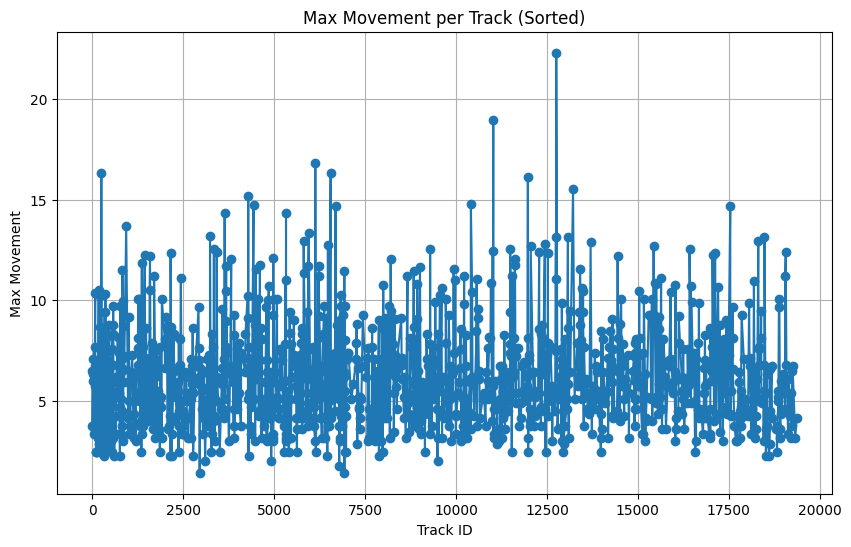

In [12]:
# Sort the DataFrame by 'track_id'
graph = sorted_max_movement_with_index.sort_values(by='track_id')

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(graph['track_id'], graph['total_movement'], marker='o', linestyle='-')
plt.xlabel('Track ID')
plt.ylabel('Max Movement')
plt.title('Max Movement per Track (Sorted)')
plt.grid(True)
plt.show()

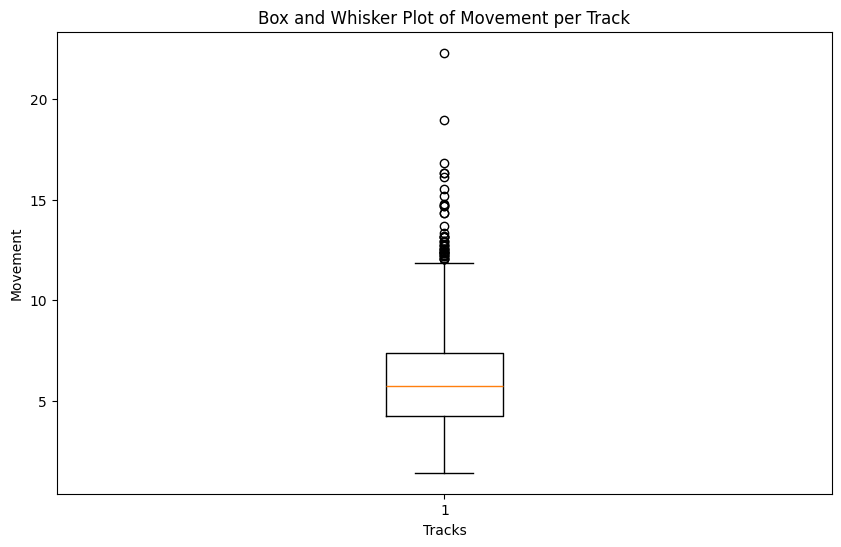

In [13]:

# Assuming you have a DataFrame named sorted_max_movement_with_index
# If you haven't sorted it, you can sort it as mentioned in the previous responses

# Plot the box and whisker plot
plt.figure(figsize=(10, 6))
plt.boxplot(sorted_max_movement_with_index['total_movement'])
plt.xlabel('Tracks')
plt.ylabel('Movement')
plt.title('Box and Whisker Plot of Movement per Track')
plt.show()


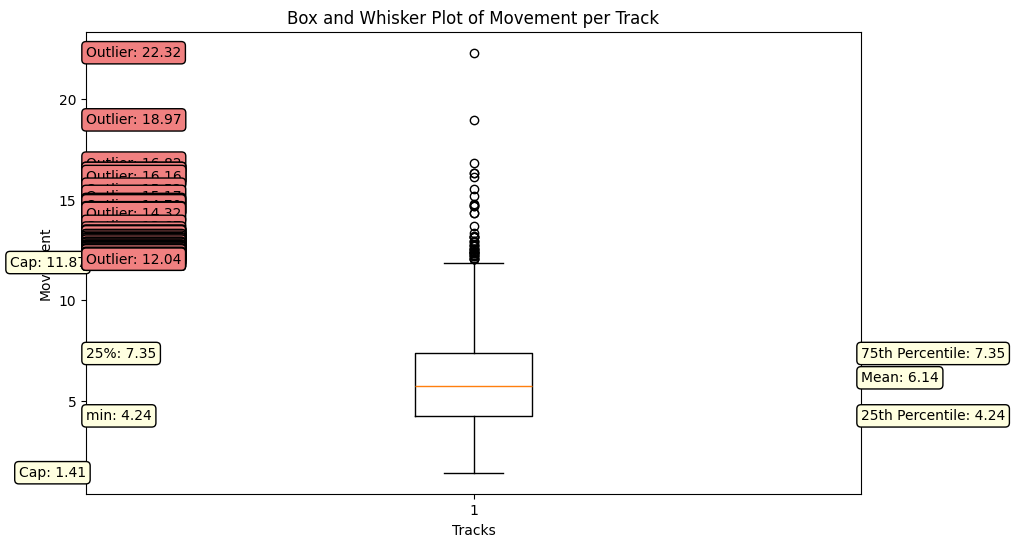

In [14]:

# Assuming you have a DataFrame named sorted_max_movement_with_index
# If you haven't sorted it, you can sort it as mentioned in the previous responses

# Plot the box and whisker plot
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(sorted_max_movement_with_index['total_movement'])

# Add annotations for edges (minimum, 25th percentile, median, 75th percentile, maximum)
edges = ['min', '25%', 'median', '75%', 'max']
values = [item.get_ydata()[0] for item in boxplot['whiskers']]

for edge, value in zip(edges, values):
    plt.text(0.5, value,
             f'{edge}: {value:.2f}',
             horizontalalignment='right' if edge == 'max' else 'left',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow")
             )

# Add annotations for caps
for value in [item.get_ydata()[0] for item in boxplot['caps']]:
    plt.text(0.5, value,
             f'Cap: {value:.2f}',
             horizontalalignment='right',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow")
             )

# Add annotations for outliers
outlier_values = boxplot['fliers'][0].get_ydata()
for value in outlier_values:
    plt.text(0.5, value,
             f'Outlier: {value:.2f}',
             horizontalalignment='left',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightcoral")
             )

# Add annotations for 25th percentile, mean, and 75th percentile
for value, label in zip([sorted_max_movement_with_index['total_movement'].quantile(0.25),
                         sorted_max_movement_with_index['total_movement'].mean(),
                         sorted_max_movement_with_index['total_movement'].quantile(0.75)],
                        ['25th Percentile', 'Mean', '75th Percentile']):
    plt.text(1.5, value,
             f'{label}: {value:.2f}',
             horizontalalignment='left',
             verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="lightyellow")
             )

plt.xlabel('Tracks')
plt.ylabel('Movement')
plt.title('Box and Whisker Plot of Movement per Track')

plt.show()
